## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [24]:
import os
import keras
import itertools

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [25]:
train, test = keras.datasets.cifar10.load_data()

In [26]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [27]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [28]:
from keras.regularizers import l1_l2

"""
建立神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [29]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [30]:
results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}



Experiment with L1 = 0.010000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/500

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 124us/step - loss: 198.6897 - accuracy: 0.2455 - val_loss: 41.1240 - val_accuracy: 0.2244
Epoch 2/10
50000/50000 [==============================] - 6s 118us/step - loss: 19.1091 - accuracy: 0.1155 - val_loss: 7.2935 - val_accuracy: 0.1000
Epoch 3/10
50000/50000 [==============================] - 6s 118us/step - loss: 4.1228 - accuracy: 0.1000 - val_loss: 2.6531 - val_accuracy: 0.1000
Epoch 4/10
50000/50000 [==============================] - 6s 119us/step - loss: 2.4874 - accuracy: 0.0970 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 5/10
50000/50000 [==============================] - 6s 119us/step - loss: 2.4626 - accuracy: 0.0988 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 6/10
50000/50000 [==============================] - 6s 121us/step - loss: 2.4626 - accuracy: 0.0968 - val_loss: 2.4627 - val_accuracy: 0.1000
Epoch 7/10
50000/50000 [==============================] - 

50000/50000 [==============================] - 7s 135us/step - loss: 5.7023 - accuracy: 0.3915 - val_loss: 5.6415 - val_accuracy: 0.4082
Epoch 4/10
50000/50000 [==============================] - 7s 130us/step - loss: 5.5723 - accuracy: 0.4145 - val_loss: 5.5157 - val_accuracy: 0.4254
Epoch 5/10
50000/50000 [==============================] - 6s 129us/step - loss: 5.4565 - accuracy: 0.4290 - val_loss: 5.4092 - val_accuracy: 0.4354
Epoch 6/10
50000/50000 [==============================] - 7s 134us/step - loss: 5.3498 - accuracy: 0.4435 - val_loss: 5.3253 - val_accuracy: 0.4371
Epoch 7/10
50000/50000 [==============================] - 6s 129us/step - loss: 5.2495 - accuracy: 0.4539 - val_loss: 5.2214 - val_accuracy: 0.4499
Epoch 8/10
50000/50000 [==============================] - 6s 128us/step - loss: 5.1534 - accuracy: 0.4635 - val_loss: 5.1296 - val_accuracy: 0.4579
Epoch 9/10
50000/50000 [==============================] - 6s 129us/step - loss: 5.0606 - accuracy: 0.4734 - val_loss: 5.043

Epoch 6/10
50000/50000 [==============================] - 6s 125us/step - loss: 5.2546 - accuracy: 0.4384 - val_loss: 5.2174 - val_accuracy: 0.4444
Epoch 7/10
50000/50000 [==============================] - 6s 118us/step - loss: 5.1579 - accuracy: 0.4526 - val_loss: 5.1243 - val_accuracy: 0.4547
Epoch 8/10
50000/50000 [==============================] - 6s 117us/step - loss: 5.0669 - accuracy: 0.4626 - val_loss: 5.0450 - val_accuracy: 0.4558
Epoch 9/10
50000/50000 [==============================] - 6s 119us/step - loss: 4.9813 - accuracy: 0.4708 - val_loss: 4.9621 - val_accuracy: 0.4659
Epoch 10/10
50000/50000 [==============================] - 6s 127us/step - loss: 4.8951 - accuracy: 0.4788 - val_loss: 4.8939 - val_accuracy: 0.4671
Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         

Epoch 9/10
50000/50000 [==============================] - 6s 125us/step - loss: 1.4853 - accuracy: 0.4786 - val_loss: 1.5062 - val_accuracy: 0.4653
Epoch 10/10
50000/50000 [==============================] - 6s 126us/step - loss: 1.4599 - accuracy: 0.4863 - val_loss: 1.4969 - val_accuracy: 0.4702
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_______________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 147us/step - loss: 2.1730 - accuracy: 0.2772 - val_loss: 2.0056 - val_accuracy: 0.3495
Epoch 2/10
50000/50000 [==============================] - 8s 151us/step - loss: 1.9454 - accuracy: 0.3700 - val_loss: 1.8940 - val_accuracy: 0.3884
Epoch 3/10
50000/50000 [==============================] - 7s 146us/step - loss: 1.8580 - accuracy: 0.3993 - val_loss: 1.8337 - val_accuracy: 0.4030
Epoch 4/10
50000/50000 [==============================] - 7s 146us/step - loss: 1.7979 - accuracy: 0.4201 - val_loss: 1.7837 - val_accuracy: 0.4197
Epoch 5/10
50000/50000 [==============================] - 8s 168us/step - loss: 1.7517 - accuracy: 0.4365 - val_loss: 1.7499 - val_accuracy: 0.4343
Epoch 6/10
50000/50000 [==============================] - 7s 142us/step - loss: 1.7105 - accuracy: 0.4517 - val_loss: 1.7210 - val_accuracy: 0.4482
Epoch 7/10
50000/50000 [==============================] - 8s 1

50000/50000 [==============================] - 7s 140us/step - loss: 1.7309 - accuracy: 0.3948 - val_loss: 1.6970 - val_accuracy: 0.4097
Epoch 4/10
50000/50000 [==============================] - 8s 163us/step - loss: 1.6727 - accuracy: 0.4191 - val_loss: 1.6569 - val_accuracy: 0.4189
Epoch 5/10
50000/50000 [==============================] - 7s 148us/step - loss: 1.6243 - accuracy: 0.4344 - val_loss: 1.6178 - val_accuracy: 0.4356
Epoch 6/10
50000/50000 [==============================] - 6s 127us/step - loss: 1.5860 - accuracy: 0.4460 - val_loss: 1.5809 - val_accuracy: 0.4437
Epoch 7/10
50000/50000 [==============================] - 7s 133us/step - loss: 1.5515 - accuracy: 0.4574 - val_loss: 1.5546 - val_accuracy: 0.4556
Epoch 8/10
50000/50000 [==============================] - 6s 125us/step - loss: 1.5205 - accuracy: 0.4686 - val_loss: 1.5430 - val_accuracy: 0.4562
Epoch 9/10
50000/50000 [==============================] - 6s 120us/step - loss: 1.4933 - accuracy: 0.4776 - val_loss: 1.507

Epoch 6/10
50000/50000 [==============================] - 7s 136us/step - loss: 1.5672 - accuracy: 0.4522 - val_loss: 1.5698 - val_accuracy: 0.4475
Epoch 7/10
50000/50000 [==============================] - 7s 138us/step - loss: 1.5368 - accuracy: 0.4623 - val_loss: 1.5382 - val_accuracy: 0.4528
Epoch 8/10
50000/50000 [==============================] - 6s 129us/step - loss: 1.5070 - accuracy: 0.4728 - val_loss: 1.5136 - val_accuracy: 0.4606
Epoch 9/10
50000/50000 [==============================] - 6s 127us/step - loss: 1.4797 - accuracy: 0.4808 - val_loss: 1.5225 - val_accuracy: 0.4595
Epoch 10/10
50000/50000 [==============================] - 7s 130us/step - loss: 1.4571 - accuracy: 0.4916 - val_loss: 1.4785 - val_accuracy: 0.4770
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         

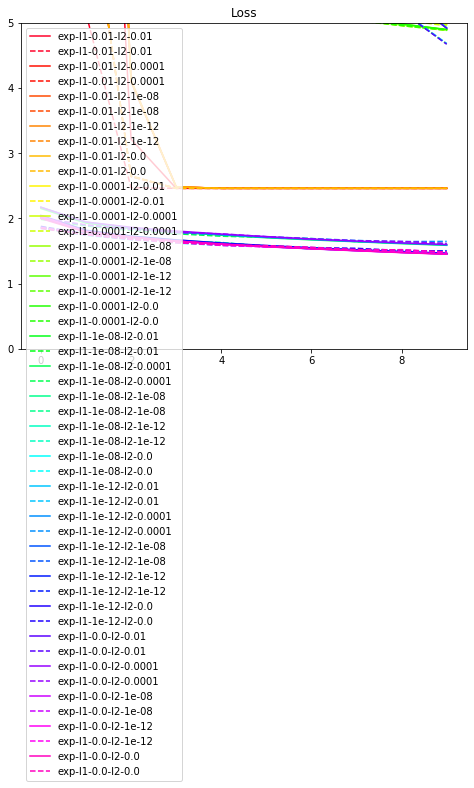

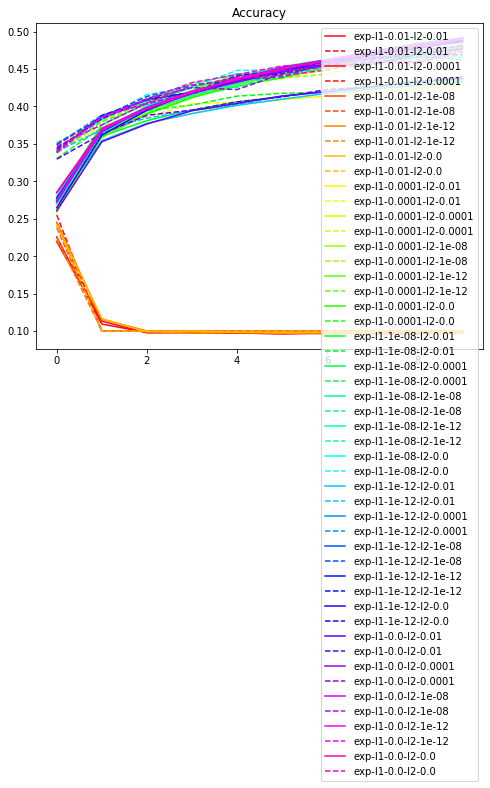

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()